/home/betekmen/IGEM/old/old_analysis


/tmp/ipykernel_3903859/2553671480.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


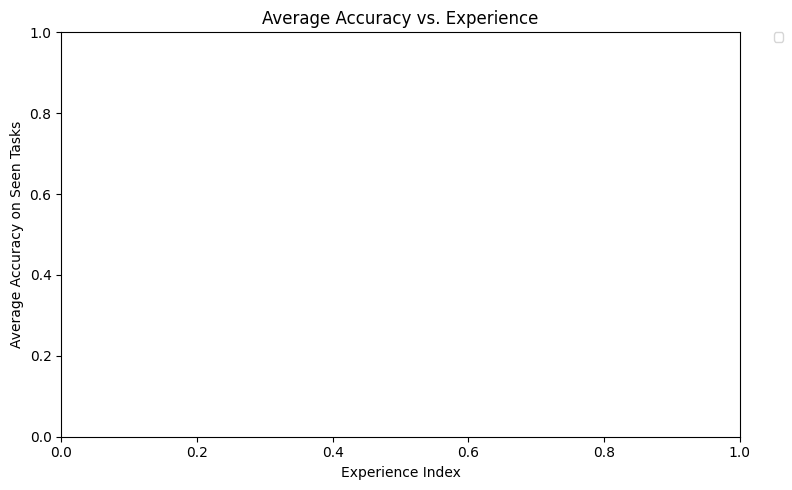

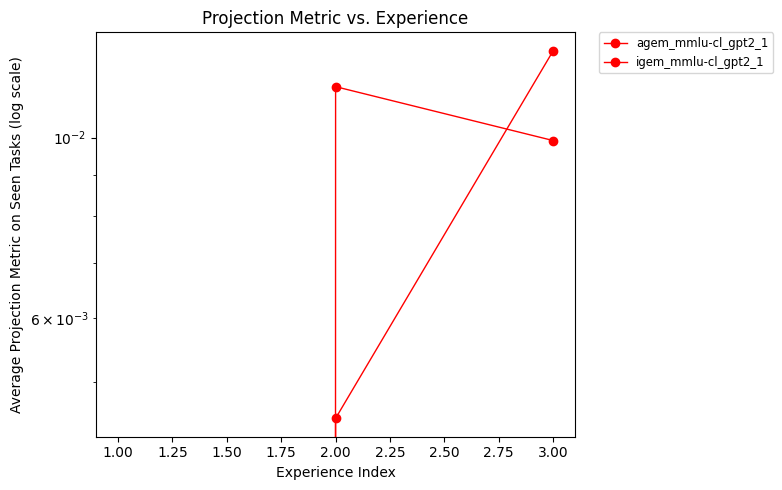

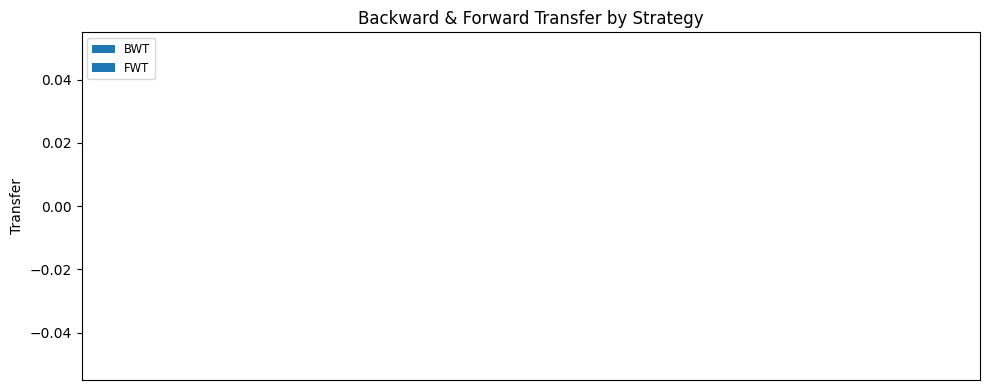

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
print(os.getcwd())
# Configuration
eval_path = '../../new_results/debug'
#eval_path = '../debug_results/minitest/'
metrics = {
    "Projection": "Projection",
    "Accuracy": "Top1_Acc_Exp/eval_phase/test_stream/Exp"
}

def load_metric_data(path, metric_patterns):
    data = {}
    exp_regex = re.compile(r"Exp(\d+)")
    for fn in os.listdir(path):
        if not fn.lower().endswith('.csv'):
            continue
        if "_gem_1.csv" in fn:
            continue

        df = pd.read_csv(os.path.join(path, fn))
        for name, pat in metric_patterns.items():
            raw = [c for c in df.columns if pat in c]
            cols = [c for c in raw if exp_regex.search(c)]
            if not cols:
                continue

            cols.sort(key=lambda c: int(exp_regex.search(c).group(1)))
            df_sub = df[cols]
            n = len(cols)
            means = [df_sub.iloc[i, :i+1].mean() for i in range(n)]
            data[f"{fn}||{name}"] = means

    return data

# Load and parse
metric_data = load_metric_data(eval_path, metrics)

def parse_strategies(data_dict):
    """
    From "filename||Metric" keys, produce list of tuples:
    (truncated_label, curve, plugin_name, iter_count)
    """
    strategies = []
    for key, curve in data_dict.items():
        fn = key.split("||")[0]
        base = os.path.splitext(fn)[0]            # strip .csv
        # truncate after "_mlp_"
        if "_mlp_" in base:
            truncated = base.split("_mlp_", 1)[1]
        else:
            truncated = base
        # split into plugin and iteration
        if "_n_iter_" in truncated:
            plugin_part, iter_part = truncated.rsplit("_n_iter_", 1)
            plugin = plugin_part if plugin_part else "gem"
            iter_count = iter_part
        else:
            plugin = "gem"
            iter_count = ""
        strategies.append((truncated, curve, plugin, iter_count))
    # sort by the truncated label
    strategies.sort(key=lambda x: x[0].lower())
    return strategies

acc_strats  = parse_strategies({k: v for k, v in metric_data.items() if k.endswith("||Accuracy")})
proj_strats = parse_strategies({k: v for k, v in metric_data.items() if k.endswith("||Projection")})

# define line‐style and width per iteration count
style_map = {'1': '-', '25': ':', '100': '--', '500': '-.'}
width_map = {'1': 0.5, '25': 1.0, '100': 1.5, '500': 2.0}

# assign a color per plugin
plugins = sorted({p for _, _, p, _ in acc_strats + proj_strats})
cmap = plt.get_cmap('tab20')
color_list = cmap(np.linspace(0, 1, len(plugins)))
base_colors = ['red', 'green', 'blue', 'magenta', 'orange', 'cyan']
 # a tuple of 10 RGBA values

# Make sure you never need more than 10
if len(plugins) > len(base_colors):
    raise ValueError(f"{len(plugins)} plugins but only {len(base_colors)} tab10 colors available")

# Assign each plugin a unique color
plugin_colors = { plugin: base_colors[i] for i, plugin in enumerate(plugins) }
# ---- Plot: Accuracy curves ----
plt.figure(figsize=(8, 5))
for label, curve, plugin, iter_count in acc_strats:
    color = plugin_colors[plugin]
    linestyle = style_map.get(iter_count, '-')
    lw = width_map.get(iter_count, 1.0)
    plt.plot(
        range(1, len(curve) + 1),
        curve,
        marker='o',
        label=label,
        color=color,
        linestyle=linestyle,
        linewidth=lw
    )

plt.xlabel('Experience Index')
plt.ylabel('Average Accuracy on Seen Tasks')
plt.title('Average Accuracy vs. Experience')
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

# ---- Plot: Projection curves ----
plt.figure(figsize=(8, 5))
for label, curve, plugin, iter_count in proj_strats:
    color = plugin_colors[plugin]
    linestyle = style_map.get(iter_count, '-')
    lw = width_map.get(iter_count, 1.0)
    plt.plot(
        range(1, len(curve) + 1),
        curve,
        marker='o',
        label=label,
        color=color,
        linestyle=linestyle,
        linewidth=lw
    )
plt.yscale('log') 
plt.xlabel('Experience Index')
plt.ylabel('Average Projection Metric on Seen Tasks (log scale)')
plt.title('Projection Metric vs. Experience')
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

# ---- Compute & Plot Backward & Forward Transfer ----
import os
import re
import numpy as np

exp_regex = re.compile(r"Exp(\d+)")
baseline = 1.0 / 10  # chance‐level on 10‐way permuted‐MNIST

# gather each strategy’s filename
strat_files = sorted({k.split("||")[0] for k in metric_data if k.endswith("||Accuracy")})

bwt_list = []
fwt_list = []
labels   = []

for fn in strat_files:
    # load raw accuracy matrix
    df = pd.read_csv(os.path.join(eval_path, fn))
    # pick & sort the same columns used for Accuracy
    cols = [c for c in df.columns if metrics["Accuracy"] in c and exp_regex.search(c)]
    cols.sort(key=lambda c: int(exp_regex.search(c).group(1)))

    R = df[cols].to_numpy()   # shape (n_exps, n_exps)
    N = R.shape[1]

    # Forward Transfer: performance on task j *before* training on it
    # minus baseline, i.e. R[j-1, j] - baseline, for j=1..N-1
    fwt_vals = [R[j-1, j] - baseline for j in range(1, N)]
    avg_fwt  = np.mean(fwt_vals)

    # Backward Transfer: how much you retain task j at end vs right after you saw it
    # i.e. R[N-1, j] - R[j-1, j], for j=1..N-1
    bwt_vals = [R[-1,   j] - R[j-1, j] for j in range(1, N)]
    avg_bwt  = np.mean(bwt_vals)

    labels.append(os.path.splitext(fn)[0])
    fwt_list.append(avg_fwt)
    bwt_list.append(avg_bwt)

# bar‐plot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x - width/2, bwt_list, width, label='BWT')
ax.bar(x + width/2, fwt_list, width, label='FWT')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Transfer')
ax.set_title('Backward & Forward Transfer by Strategy')
ax.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()
